In [4]:
import numpy as np, cv2, glob, time, itertools, scipy
import pandas as pd, matplotlib.pyplot as plt
#import plotly.express as px
from operator import itemgetter
from evaluation_mcc import *
import os
os.environ['OPENCV_IO_ENABLE_JASPER'] = 'true'

In [5]:
# Parameters
tf, qf, Na, St, Tt, Ct, Tf, Td, bsize = 4, .25, 3, 3, 0.06, 3, 50, 40, 8
zz_mat = [0,0, 0,1, 1,0, 2,0, 1,1, 0,2, 0,3, 1,2, 2,1, 3,0, 4,0, 3,1, 2,2, 1,3, 0,4, 0,5, 1,4, 2,3, 3,2, 4,1, 5,0, 6,0, 5,1, 4,2, 3,3, 2,4, 1,5, 0,6, 0,7, 1,6, 2,5, 3,4, 4,3, 5,2, 6,1, 7,0]
zzidx = [0,0, 0,1, 1,0, 2,0, 1,1, 0,2, 0,3, 1,2, 2,1, 3,0, 3,1, 2,2, 1,3, 2,3, 3,2, 3,3]

In [6]:
# DCT on disjoint blocks of size B
def dct_blocks(img, B):
    h, w = img.shape
    img = img.astype(float)
    blocks = np.lib.stride_tricks.as_strided(img, shape=(h - B + 1, w - B +1, B, B), strides=img.strides + img.strides)
    bh, bw = blocks.shape[:2]
    dct = [[(i, j), zigzag_sort((cv2.dct(blocks[i][j]) * qf + .5).astype(int).tolist())] for (i,j) in itertools.product(range(bh), range(bw))]
    return dct

In [7]:
def zigzag_sort(a):
    b = []
    for i in range(0, 2 * tf**2, 2):
        b.append(a[zz_mat[i]][zz_mat[i + 1]])
    return b

In [8]:
def get_image_results(img, tv):
    img_res = np.zeros(img.shape, dtype = 'uint8')
    s = sorted(tv, key = lambda k: len(tv[k]), reverse=True)[:4]
    for k in s:
        v = tv[k]
        if len(v) > Tf:
            for x in v:
                img_res[x[0], x[1]] = 1
                img_res[x[0] + k[0], x[1] + k[1]] = 1
    return img_res

In [9]:
def compare(A, tv):
    if A == None or len(A) == 0:
        return
    a = A[0]
    for b in A[1:]:
        ai, aj = np.array(a[1]), np.array(b[1])
        idxi, idxj = np.array(a[0]), np.array(b[0])
        v = (idxj[0] - idxi[0], idxj[1] - idxi[1])
        if np.linalg.norm(v) > Td:
            rmax, rmin = -5000, 5000
            c = 0
            for l in range(len(aj)):
                if aj[l] == 0:
                    if abs(ai[l] - aj[l]) >= St:
                        c += 1
                else:
                    r = 1.0*ai[l] / aj[l]
                    if r < rmin:
                        rmin = r
                    if r > rmax:
                        rmax = r
            if rmax - rmin >= Tt:
                c += 1
            if c < Ct:
                idx = idxi
                if v[0] < 0:
                    v = (-v[0], -v[1])
                    idx = idxj
                if tv.get(v) == None:
                    tv[v] = []
                tv[v].append(idx)

In [15]:
def locate_copy_move_region_dct(img):
    # DCT and main frequency extraction
    start = time.time()
    A = dct_blocks(img, bsize)
    print('DCT: {} seconds'.format(time.time() - start))
    start = time.time()
    A = sorted(A, key=itemgetter(1), reverse=True)
    print('SORT: {} seconds'.format(time.time() - start))
    start = time.time()
    # Dictionary of transfer vectors
    tv = {}
    AA = list(map(lambda i: A[i: i+Na], list(range(len(A) - Na))))
    print('NEIGH: {} seconds'.format(time.time() - start))
    start = time.time()
    list(map(lambda X: compare(X, tv), AA))
    print('COMPARE: {} seconds'.format(time.time() - start))
    start = time.time()
    img_res = get_image_results(img, tv)
    print('RESULTS: {} seconds'.format(time.time() - start))
    return img_res

In [17]:
evaluation_metrics = pd.DataFrame(columns=['DATASET','COMPRESSION_TYPE','IMAGE','COMPRESSION_LEVEL','ACCURACY', 'F1_SCORE', 'MCC', 'JACCARD'])
evaluation_metrics

,DATASET,COMPRESSION_TYPE,IMAGE,COMPRESSION_LEVEL,ACCURACY,F1_SCORE,MCC,JACCARD


,DATASET,COMPRESSION_TYPE,IMAGE,COMPRESSION_LEVEL,ACCURACY,F1_SCORE,MCC,JACCARD


In [67]:
dresden_set = [21782, 21784, 21796, 21812, 21814, 21826, 21830, 21838, 21846, 21854, 21856, 21860, 21868, 21884, 21892, 21896, 21898, 21906, 21908]
trace_set = ['r00a940e1t', 'r0a2e85f0t', 'r0a2ff882t', 'r0a3c52a0t', 'r0a4ce555t', 'r0a5d7cb6t', 'r0a8b59bbt', 'r0a8e5f8at', 'r0a10fe29t', 'r0a18e454t', 'r0a19cb85t', 'r0a31a2cct', 'r0a42c0f6t', 'r0a54ed98t', 'r0a64ce0bt', 'r0a71c689t', 'r0a779af2t', 'r0a0852c6t', 'r0a9384b1t', 'r0a72568ct']

path_to_images = 'D:/semester01/Multimedia-Security/armas-dct-copy/images/COMPLETE_DATASET/'

#datasets = ['comofod']
#datasets = ['comofod','dresden','trace']
#datasets = ['dresden','trace']
datasets = ['trace']

compression_types = ['jpeg']
#compression_types = ['jpeg','jp2','jxl']
#compression_types = ['jxl']

#images = 3
images = len(trace_set)
#images = 20

#compression_levels = [7, 8, 9]
#compression_levels = [1, 2, 3, 4, 5, 6, 7, 8, 9]
#compression_levels = [85, 90, 95, 100]
compression_levels = [80, 85, 90, 95, 100]
#compression_levels = [80, 90]



Perform DCT Code of Esteban on COMOFOD Images

In [68]:
for dataset in datasets:
    print(f"dataset: ", dataset)

    for compression_type in compression_types:
        print(f"compression type: ", compression_type)

        for image in range(1,2):
            print(f"image: ", image)

            for compression_level in compression_levels:
                print(f"compression level: ", compression_level)

                if dataset == 'dresden':
                    path_in = path_to_images + dataset + '/Nikon_D70s_0_' + str(trace_set[image]) + '_' + str(compression_level) + '.' + compression_type + '.png'
                    #path_in = 'images/comofod/00' + str(image) + '_F_JC' + str(compression_level) + '.jpg'
                    path_out = path_in + '.result.png'

                elif dataset == 'trace':
                    print('trace')
                    path_in = path_to_images + dataset + '/' + str(trace_set[image]) + '_' + str(compression_level) + '.' + compression_type + '.png'
                    path_out = path_in + '.result.png'
                    #path_in = 'images/comofod/0' + str(image) + '_F_JC' + str(compression_level) + '.jpg'
                    #path_out = 'images/comofod/0' + str(image) + '_F_JC' + str(compression_level) + '.jpg-result.jpg'
                print(path_in)
                img = cv2.imread(path_in, 0)
                result = locate_copy_move_region_dct(img)

                cv2.imwrite(path_out, result*255)

dataset:  trace
compression type:  jpeg
image:  1
compression level:  85
trace
D:/semester01/Multimedia-Security/armas-dct-copy/images/COMPLETE_DATASET/trace/r0a2e85f0t_85.jpeg.png
DCT: 84.55880308151245 seconds
SORT: 7.76332688331604 seconds
NEIGH: 16.092533826828003 seconds
COMPARE: 184.70190954208374 seconds
RESULTS: 0.9357786178588867 seconds
compression level:  90
trace
D:/semester01/Multimedia-Security/armas-dct-copy/images/COMPLETE_DATASET/trace/r0a2e85f0t_90.jpeg.png
DCT: 37.53323721885681 seconds
SORT: 8.176225423812866 seconds
NEIGH: 16.65799045562744 seconds
COMPARE: 191.6217601299286 seconds
RESULTS: 0.952308177947998 seconds
compression level:  95
trace
D:/semester01/Multimedia-Security/armas-dct-copy/images/COMPLETE_DATASET/trace/r0a2e85f0t_95.jpeg.png
DCT: 73.07098364830017 seconds
SORT: 15.730809688568115 seconds
NEIGH: 12.93699312210083 seconds
COMPARE: 312.3896691799164 seconds
RESULTS: 2.1610395908355713 seconds
compression level:  100
trace
D:/semester01/Multimedia-

In [36]:
compression_types

['jpeg', 'jp2', 'jxl']

Perform Evaluation on Images

In [66]:
for dataset in datasets:
    print(dataset)

    for compression_type in compression_types:
        print(compression_type)

        for image in range(1,images+1):
            print(image)

            for compression_level in compression_levels:
                print(compression_level)

                if image < 50:
                    ground_truth_path = 'D:/semester01/Multimedia-Security/armas-dct-copy/images/COMPLETE_DATASET/' + dataset + '/' + str(trace_set[image]) + '_mask.png'
                    predicted_path = 'D:/semester01/Multimedia-Security/armas-dct-copy/images/COMPLETE_DATASET/' + dataset + '/' + str(trace_set[image]) + '_' + str(compression_level) + '.' + compression_type + '.png.result.png'
                    forged_img_path = 'D:/semester01/Multimedia-Security/armas-dct-copy/images/COMPLETE_DATASET/' + dataset + '/' + str(trace_set[image]) + '_' + str(compression_level) + '.' + compression_type + '.png'

                #ground_truth = cv2.imread("D:/semester01/Multimedia-Security/armas-dct-copy/images/002_B.png", 0)
                ground_truth = cv2.imread(ground_truth_path,0)
                #predicted = cv2.imread("D:/semester01/Multimedia-Security/armas-dct-copy/images/002_F_JC8.jpg-result.jpg", 0)
                predicted = cv2.imread(predicted_path,0)
                #forged_img = cv2.imread("D:/semester01/Multimedia-Security/armas-dct-copy/images/002_F_JC8.jpg")
                forged_img = cv2.imread(forged_img_path)

                print(forged_img_path)

                validation_metrics = evaluate_mcc(ground_truth,predicted,forged_img)
                evaluation_metrics.loc[len(evaluation_metrics.index)] = [dataset, compression_type, str(image), compression_level, validation_metrics['accuracy'], validation_metrics['f1_score'], validation_metrics['mcc'], validation_metrics['jaccard_similarity']]
                print(evaluation_metrics)

evaluation_metrics.to_csv('D:/semester01/Multimedia-Security/armas-dct-copy/evaluation_metrics_trace.csv')

trace
jpeg
1
80
D:/semester01/Multimedia-Security/armas-dct-copy/images/COMPLETE_DATASET/trace/r0a2e85f0t_80.jpeg.png


KeyboardInterrupt: 

In [35]:
img = cv2.imread(r'D:\semester01\Multimedia-Security\armas-dct-copy\images\jxl_comofod\test.jxl')
cv2.imshow('xl img',img)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [28]:
img = plt.imread('test.jxl')
plt.imshow(img)

UnidentifiedImageError: cannot identify image file 'test.jxl'

In [7]:
path = r'D:\semester01\Multimedia-Security\armas-dct-copy\images\001_F_IB3_JP2K_Q100.jp2'

# Reading an image in default mode
image = cv2.imread(path)

# Window name in which image is displayed
window_name = 'image'

# Using cv2.imshow() method
# Displaying the image
cv2.imshow(window_name, image)

# waits for user to press any key
# (this is necessary to avoid Python kernel form crashing)
cv2.waitKey(0)

# closing all open windows
cv2.destroyAllWindows()

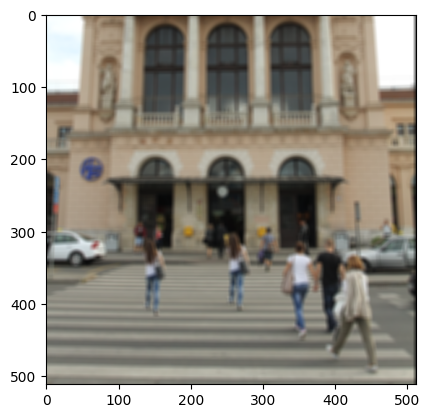

In [6]:
image = plt.imread(path)
plt.imshow(image)